# Conceit
I want to try and simulate/model NFL games via a Monte Carlo methodology. The idea is to choose drives from a team's history and use them to construct a complete football game. In its simplest form, this will look like randomly choosing drive outcomes from a team's history. In a more realistic model, the game situation should guide what drive outcomes are more likely; a drive starting with 20 seconds to go in the half is much less likely to result in a touchdown or field goal than an opening drive.

In this document, I aim to use drive-level history and this kind of Monte Carlo simulation to find and implement a reasonable way to model NFL football games.

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import math
import pprint

In [2]:
# Read drive-level data from csv
alldrives = pd.read_csv('../data/espn_drives2009-2017.csv')
alldrives.sample(5)

,Unnamed: 0,away,away_score_after,away_score_before,drive,home,home_score_after,home_score_before,offense,plays,...,uid,TD,FG,punt,turnover,EoH,secs_rem,starting_fieldposition,time_in_secs,left_in_half
40208,40208,SD,3,3,10,KC,12,12,SD,6,...,400791715-10,0,0,1,0,0,1540.0,-44.0,163,1540.0
15438,15438,DAL,44,44,19,BUF,7,7,BUF,8,...,311113006-19,0,0,0,1,0,294.0,-30.0,233,294.0
37242,37242,GB,13,13,14,SEA,17,10,SEA,5,...,400791708-14,1,0,0,0,0,1413.0,-4.0,105,1413.0
46459,46459,TB,14,14,16,SEA,5,5,SEA,4,...,400874665-16,0,0,1,0,0,1203.0,-41.0,153,1203.0
27774,27774,TEN,10,7,18,JAX,20,20,TEN,11,...,331110010-18,0,1,0,0,0,1517.0,-30.0,302,1517.0


In [3]:
alldrives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54298 entries, 0 to 54297
Data columns (total 24 columns):
Unnamed: 0                54298 non-null int64
away                      54298 non-null object
away_score_after          54298 non-null int64
away_score_before         54298 non-null int64
drive                     54298 non-null int64
home                      54298 non-null object
home_score_after          54298 non-null int64
home_score_before         54298 non-null int64
offense                   54298 non-null object
plays                     54298 non-null int64
result                    54298 non-null object
time                      54298 non-null object
yds_gained                54298 non-null int64
gameId                    54298 non-null int64
uid                       54298 non-null object
TD                        54298 non-null int64
FG                        54298 non-null int64
punt                      54298 non-null int64
turnover                  54298 non-nul

In [4]:
gamedata = pd.read_csv('../data/espn_gamedata2009-2017.csv')
gamedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 10 columns):
gameId        2306 non-null int64
result        2306 non-null object
season        2306 non-null int64
week          2306 non-null int64
home          2297 non-null object
away          2297 non-null object
winner        2306 non-null object
home_score    2306 non-null object
away_score    2306 non-null object
OT            2306 non-null object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


In [5]:
# Include time information on these plays
alldrives = alldrives.merge(
                right=gamedata[['gameId','season','week']],
                how='left',
                left_on='gameId',
                right_on='gameId')

Given game situation, write a function to make a set of possible drives that could come next. Then choose one of those drives.

In simple case, game situation means home team, away team, whether the home team should be the offense, and how much time is remaining in the half. To make the list of possible next drives, filter all drives for those where the offensive team has posession or the defensive team does not have posession. In addition, the drive time should be <= the time remaining in the simulated game's half.

In [6]:
# game_situation (home, away, home_poss, time_rem)

home = 'CAR'
away = 'MIA'
home_poss = True
time_rem = 150

# Set some keywords for the filter
if home_poss:
    off_team = home
    def_team = away  
else:
    off_team = away
    def_team = home
    
# Filter for plays for this offense and defense
teamdrives = alldrives.loc[ 
           # Condition 1: team is the offense
           ( 
             alldrives.offense.astype(str) == off_team 
           ) 
           |  # OR
           # Condition 2:
           ( # Defensive team is home or away
             ( 
               (alldrives.home.astype(str) == def_team) |
               (alldrives.away.astype(str) == def_team)
             ) 
             &  # AND
               # not the offense
             (alldrives.offense.astype(str) != def_team)
           )
         ]

possible_drives = teamdrives[ teamdrives.time_in_secs <= time_rem ]

possible_drives.sample(5)

,Unnamed: 0,away,away_score_after,away_score_before,drive,home,home_score_after,home_score_before,offense,plays,...,FG,punt,turnover,EoH,secs_rem,starting_fieldposition,time_in_secs,left_in_half,season,week
18861,18861,MIA,21,21,22,OAK,13,10,OAK,5,...,1,0,0,0,975.0,25.0,85,975.0,2012,2
49959,49959,MIA,10,10,15,TEN,3,3,TEN,5,...,0,1,0,0,1900.0,-19.0,77,100.0,2017,5
14353,14353,NYJ,7,7,6,MIA,3,3,NYJ,3,...,0,1,0,0,2950.0,-18.0,113,1150.0,2011,6
18614,18614,HOU,30,30,26,MIA,10,10,HOU,4,...,0,0,0,1,104.0,11.0,104,104.0,2012,1
34035,34035,PHI,0,0,0,CAR,0,0,CAR,2,...,0,0,1,0,3600.0,0.0,55,1800.0,2014,10


Now, given a list of possible drives, assign a weight to each, and choose one based on the weights.

In [7]:
# Assign weight to each drive. Start simple
drives = possible_drives.index.values.tolist()
drive_weights = [ 1 for d in drives ]
for i, drive in enumerate(drives):
    drive_weights[i] = 1

In [8]:
import random

# Function to return one item from a list, where each has a weight
def select(container, weights, quiet=False):
    total_weight = float(sum(weights))
    rel_weight = [w / total_weight for w in weights]

    # Probability for each element
    probs = [sum(rel_weight[:i + 1]) for i in range(len(rel_weight))]
    
    r = random.random()
    for (i, element) in enumerate(container):
        if r <= probs[i]:
            if not quiet:
                print("^",element,rel_weight[i])
            break

    return element

In [9]:
drive_id = select(drives, drive_weights)
possible_drives.loc[drive_id,:]

^ 33296 0.0005241090146750524


Unnamed: 0                      33296
away                              JAX
away_score_after                    3
away_score_before                   3
drive                               9
home                              MIA
home_score_after                   10
home_score_before                  10
offense                           JAX
plays                               2
result                    End of Half
time                             0:58
yds_gained                          8
gameId                      400554267
uid                       400554267-9
TD                                  0
FG                                  0
punt                                0
turnover                            0
EoH                                 1
secs_rem                         1858
starting_fieldposition              0
time_in_secs                       58
left_in_half                       58
season                           2014
week                                8
Name: 33296,

In [10]:
def get_possible_drives(home,away,home_poss,time_rem,season):

    # Set some keywords for the filter
    if home_poss:
        off_team = home
        def_team = away  
    else:
        off_team = away
        def_team = home
    
    # Filter for plays for this offense and defense
    teamdrives = alldrives.loc[ 
               # Condition 1: team is the offense
               ( 
                 alldrives.offense.astype(str) == off_team 
               ) 
               |  # OR
               # Condition 2:
               ( # Defensive team is home or away
                 ( 
                   (alldrives.home.astype(str) == def_team) |
                   (alldrives.away.astype(str) == def_team)
                 ) 
                 &  # AND
                   # not the offense
                 (alldrives.offense.astype(str) != def_team)
               )
             ]

    poss_ds = teamdrives[ (teamdrives.time_in_secs <= time_rem) 
                         & (teamdrives.season >= season-5) ]
    
    # Cut out End of Half drives unless they're relevant
#    possible_drives = poss_ds[ ~(poss_ds.EoH==1) | 
#                               ~(poss_ds.time_in_secs < time_rem) ]

    return teamdrives


def get_drive_weights(drives_df):
    # Assign weight to each drive. Start simple
    drives = drives_df.index.values.tolist()
    drive_weights = [ 1 for d in drives ]
    for i, drive in enumerate(drives):
        drive_weights[i] = 1
        
    return drive_weights

In [11]:
# Define a class that constitutes a game
class football_game:
    """Class for representing a football game"""
    def __init__(self, home ,away, season=2018, week=1, quiet=False):

        self.home = home
        self.away = away
        self.quiet = quiet
        self.season = season
        self.week = week
        self.half = 1
        self.time_rem = 1800
        self.home_score = 0
        self.away_score = 0
        self.drive_base_weights = {}
        
        # Decide which team gets the ball to start
        coin = random.randint(1,2)
        if coin == 1:
            self.home_poss = True
        else:
            self.home_poss = False
            
    
    def get_drive_base_weights(self, drives_df):
        """Return a dictionary with base weights for past plays"""
        drives = drives_df.index.values.tolist()
        base_weights = {}
        for i, d in enumerate(drives):
            drive = drives_df.loc[d,:]
            
            # Weight for recency
            if self.season < drive['season']:
                w_age = 0  # Can't use future data
            elif self.season == drive['season']:
                if self.week <= drive['week']:
                    w_age = 0
                else:
                    w_age = 2 - (self.week - drive['week']) / 16
            else:
                w_age = 1 / ( 2*(self.season - drive['season']) )
            
            # Place to add weight for home/away
            w_home = 1
            if (drive['home'] == self.home) or (drive['away'] == self.away):
                w_home = 2
                
            # Add weight to previous matchups of same teams
            w_matchup = 1
            teams = [drive['home'],drive['away']]
            if (self.home in teams) and (self.away in teams):
                w_matchup = 2
            
            base_weights[d] = w_age * w_home * w_matchup
            
        return base_weights
                 
            
    def get_drive_weights(self, drives_df):
        drives = drives_df.index.values.tolist()
        drive_weights = [ 1 for d in drives ]
        # Get current score difference
        if self.home_poss:
            curr_score_diff = self.home_score - self.away_score
        else:
            curr_score_diff = self.away_score - self.home_score        

        for i, d in enumerate(drives):
            drive = drives_df.loc[d,:]
            w_base = self.drive_base_weights[d]

            # Gaussian function for selecting plays with similar time remaining in half
            w_time = 0
            if self.time_rem > 300:
                # Most of the time, time remaining won't dictate decisions.
                w_time = 1
            elif (not drive.EoH==1) or (drive.time_in_secs < self.time_rem + 10):
                    
                numerator = drive['left_in_half'] - self.time_rem
                # Scale variance in Gaussian by time remaining. More possibilities with more time left
                stdev = self.time_rem / 3
                w_time = math.exp( (numerator)**2 / (-2*stdev**2) )

            # Get score difference before this drive
            if drive['offense'] == drive['home']:
                hist_score_diff = drive['home_score_before'] - drive['away_score_before']
            elif drive['offense'] == drive['away']:
                hist_score_diff = drive['away_score_before'] - drive['home_score_before']
                
            # Want Gaussian for plays with similar score situations
            w_score = math.exp( ( curr_score_diff - hist_score_diff )**2 / -98 )
            
            # Finally, set weight as product of the other pieces
            weight = w_base * w_time * w_score
            
            # Try and catch nans
            if math.isnan(weight):
                weight = 0
                
            drive_weights[i] = weight
                
        if not self.quiet:
            print("sum of weights = ",sum(drive_weights))
            
        return drive_weights
    
    
    def next_drive(self):
#    def next_drive(game_sit, game=game):
        """Returns a Series describing the next drive."""
    
        # Get df of possible drives
#        poss_drives = get_possible_drives(self.home, self.away, 
#                                          self.home_poss, self.time_rem)
        poss_drives = self.away_drives
        if self.home_poss:
            poss_drives = self.home_drives
            
        # Choose subset of drives based on time remaning in 1st/2nd half
        if self.time_rem > 300:
            poss_drives = poss_drives[ poss_drives.left_in_half >= 300 ]
        elif self.half == 1:
            poss_drives = poss_drives[ (poss_drives.left_in_half < 300) &
                                       (poss_drives.secs_rem > 1800) ]
        else:
            poss_drives = poss_drives[ (poss_drives.left_in_half < 300) &
                                       (poss_drives.secs_rem < 1800) ]
    
        # Get weights for the possible drives
        drive_ids = poss_drives.index.values.tolist()
        weights = self.get_drive_weights(poss_drives)
    
        # Randomly choose a drive, with weights assigned to each.
        chosen_drive_id = select(drive_ids, weights, quiet=self.quiet)
    
        return poss_drives.loc[chosen_drive_id, :]
            
            
    def get_game_sit(self):
        game_sit = (self.home,
                    self.away,
                    self.home_poss,
                    self.time_rem,
                    self.home_score,
                    self.away_score )
        return game_sit
 

    def game_sit_series(self, drive):
        # Figure out which team has possession
        if self.home_poss:
            possessor = self.home
        else:
            possessor = self.away
        
        sit_dict = {'home':self.home,
                    'away':self.away,
                    'offense':possessor,
                    'half':self.half,
                    'time_rem':self.time_rem,
                    'home_score':self.home_score,
                    'away_score':self.away_score,
                    'result':drive.result}
        return pd.Series(sit_dict)
    
    
    def game_sit_dict(self):
        # Figure out which team has possession
        if self.home_poss:
            possessor = self.home
        else:
            possessor = self.away
        
        sit_dict = {'home':self.home,
                    'away':self.away,
                    'offense':possessor,
                    'half':self.half,
                    'time_rem':self.time_rem,
                    'home_score':self.home_score,
                    'away_score':self.away_score}
        return sit_dict
    
    
    def update_game_sit(self,drive):
        """Takes a Series and updates game situation vars accordingly"""
        
        # Update clock and score
        self.time_rem -= drive.time_in_secs
        self.home_score += drive.home_score_after - drive.home_score_before
        self.away_score += drive.away_score_after - drive.away_score_before
        
        # Flip the possession arrow
        if self.home_poss:
            self.home_poss = False
        else:
            self.home_poss = True
            
            
    def record_drive(self,drive,drive_num=1):
        """Given a drive, update the proper quantities, 
        assuming dataframes for chosen drives and game history have 
        already been created"""
        # Get gamestate before this drive
        gamestate = self.game_sit_dict()
        
        # Clock changes
        gamestate_delta = {'time':drive.time_in_secs}
        if drive.time_in_secs < 10:
            gamestate_delta['time'] = 10
        
        # Score changes
        # Home team in selected drive might not be home team in sim. game
        if self.home_poss and (drive.offense == drive.home):
            flip = False
        elif self.home_poss and (drive.offense == drive.away):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.home):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.away):
            flip = False
        else:
            print("Something went wrong in determining flipped possession")
            
        if not flip:
            gamestate_delta['home_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['away_score'] = drive.away_score_after - drive.away_score_before
        else:
            gamestate_delta['away_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['home_score'] = drive.away_score_after - drive.away_score_before

        # Check for negative values in score delta
        scores_delta = (gamestate_delta['home_score'], gamestate_delta['away_score'])
        if sum([1 if (val < 0 or val > 8) else 0 for val in scores_delta]) > 0:
            # Recalculate score change based on drive result
            # Default to zero points
            gamestate_delta['home_score'] = 0
            gamestate_delta['away_score'] = 0
            if (drive.FG == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 3
                else:
                    gamestate_delta['away_score'] = 3
            elif (drive.TD == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 7
                else:
                    gamestate_delta['away_score'] = 7
                
        
        # Figure out whether possession arrow changes. Default True
        gamestate_delta['poss'] = True
        if ( (self.home_poss) & 
             (gamestate_delta['away_score'] != 0) ):
            gamestate_delta['poss'] = False
        elif ( (not self.home_poss) &
               (gamestate_delta['home_score'] != 0) ):
            gamestate_delta['poss'] = False
                    
#        # Add chosen drive to appropriate dataframe
#        drivedf = pd.Series.to_frame(drive)
#        dfs = [self.drives_selected, drivedf]
#        self.drives_selected = pd.concat( dfs, axis=1 )
        
        # Add entry to simulated game history
        this_series = pd.Series(gamestate)
        this_series['home_score_after'] = self.home_score + gamestate_delta['home_score']
        this_series['away_score_after'] = self.away_score + gamestate_delta['away_score']
        this_series['result'] = drive.result
        this_series['time'] = gamestate_delta['time']
        
        if drive_num == 1:  # Need to start gamestate dataFrame
            self.gamestate_df = pd.Series.to_frame(this_series)
        else:            # Add this series to gamestate dF
            series_df = pd.Series.to_frame(this_series)
            dfs = [ self.gamestate_df, series_df ]
            self.gamestate_df = pd.concat( dfs, axis=1 )
        
        # Update the game's state vars
        self.home_score += gamestate_delta['home_score']
        self.away_score += gamestate_delta['away_score']
        self.time_rem -= gamestate_delta['time']
        if gamestate_delta['poss']:
            self.home_poss = not self.home_poss
    
    
    def check_for_EoH(self):
        pass

In [12]:
def simulate_game( home, away, **kwargs):

    # Need new wrapper for simulating a game
    if not 'season' in kwargs:
        kwargs['season'] = 2018
    if not 'week' in kwargs:
        kwargs['week'] = 1
    if not 'quiet' in kwargs:
        kwargs['quiet'] = False
        
    newgame = football_game( home, away, **kwargs )
    
    # Assign possible drives for this game
    newgame.home_drives = get_possible_drives( home, away, True, 1800, newgame.season )
    newgame.away_drives = get_possible_drives( home, away, False, 1800, newgame.season)
    newgame.drive_base_weights = newgame.get_drive_base_weights(newgame.home_drives)
    newgame.drive_base_weights.update(newgame.get_drive_base_weights(newgame.away_drives))

    # Choose the first drive
#    game_sit = newgame.get_game_sit()
    first_drive = newgame.next_drive()

    # Make drive history DF, starting with this first drive.
    newgame.drives_selected = pd.Series.to_frame(first_drive)

    # Update game object after the first drive
    drive_num = 1
    newgame.record_drive( first_drive, drive_num )

    #while newgame.time_rem.astype(float) >= 5:
    for half in (1,2):
        newgame.half = half
        if half > 1:
            newgame.time_rem = 1800
    
        end_of_half = False
        while (not end_of_half) and (newgame.time_rem > 0):
            drive_num += 1
    
            # Choose a new drive
            this_drive = newgame.next_drive()
            # Add drive to chosen drives dataframe
            newgame.drives_selected = pd.concat( [newgame.drives_selected, this_drive], axis=1 )
        
            # Update the game object
            newgame.record_drive( this_drive, drive_num )
        
            # Check for end of Half
            if this_drive.EoH == 1:
                end_of_half = True
        
    
    # Post-game, need to transpose the dataFrames
    newgame.drives_selected = newgame.drives_selected.transpose()
    newgame.gamestate_df = newgame.gamestate_df.transpose()
    if newgame.home_score > newgame.away_score:
        newgame.winner = newgame.home
    elif newgame.away_score > newgame.home_score:
        newgame.winner = newgame.away
    else:
        newgame.winner = "TIE"
    
    
    newgame.result = {'home':newgame.home, 
                      'home_score':newgame.home_score, 
                      'away':newgame.away, 
                      'away_score':newgame.away_score,
                      'winner':newgame.winner}
    
    return newgame

In [13]:
game = simulate_game("TB",'NO',quiet=True)
print(game.result)
cols = [ 'home','away','offense','half','time_rem','time','result',
         'home_score','home_score_after','away_score','away_score_after' ]
game.gamestate_df[cols]

{'home': 'TB', 'home_score': 19, 'away': 'NO', 'away_score': 10, 'winner': 'TB'}


,home,away,offense,half,time_rem,time,result,home_score,home_score_after,away_score,away_score_after
0,TB,NO,TB,1,1800,378,Field Goal,0,6,0,0
0,TB,NO,NO,1,1422,65,Punt,6,6,0,0
0,TB,NO,TB,1,1357,233,Field Goal,6,9,0,0
0,TB,NO,NO,1,1124,138,Punt,9,9,0,0
0,TB,NO,TB,1,986,328,Field Goal,9,12,0,0
0,TB,NO,NO,1,658,123,Fumble,12,12,0,0
0,TB,NO,TB,1,535,117,Missed FG,12,12,0,0
0,TB,NO,NO,1,418,48,Touchdown,12,12,0,7
0,TB,NO,TB,1,370,256,Touchdown,12,19,7,7
0,TB,NO,NO,1,114,99,Field Goal,19,19,7,10


In [14]:
for i in range(10):
    game = simulate_game("CAR","PHI")
    print(game.result)

sum of weights =  379.325902513
^ 42363 0.000228673249736
sum of weights =  313.551762926
^ 52307 0.000431620227467
sum of weights =  288.670059004
^ 53918 0.00294234123033
sum of weights =  313.551762926
^ 46147 0.000765428196231
sum of weights =  288.670059004
^ 25243 0.00069283250466
sum of weights =  313.551762926
^ 53800 0.00135442679168
sum of weights =  379.325902513
^ 51242 0.00159896979272
sum of weights =  375.946934227
^ 45671 0.00132997493656
sum of weights =  317.263961322
^ 53356 0.000955877019856
sum of weights =  371.560973796
^ 37423 0.000444004202624
sum of weights =  360.469697191
^ 52291 0.00192129693454
sum of weights =  339.719457111
^ 41004 9.87765028524e-05
sum of weights =  12.7200787751
^ 41219 0.0105620669315
sum of weights =  3.80529394989
^ 51251 0.0864111863531
sum of weights =  225.620431828
^ 7095 0.000191851342594
sum of weights =  197.158109292
^ 9899 0.000608652013308
sum of weights =  119.552854129
^ 52315 0.0064811286567
sum of weights =  137.671528

sum of weights =  375.946934227
^ 48225 0.00121327505796
sum of weights =  379.325902513
^ 39300 0.000158372078034
sum of weights =  375.946934227
^ 26497 0.000263294553901
sum of weights =  317.263961322
^ 42696 0.0012211242425
sum of weights =  288.944751369
^ 50548 0.00209912329896
sum of weights =  317.263961322
^ 39498 0.000189352207489
sum of weights =  288.944751369
^ 53357 0.000308474161133
sum of weights =  11.3410290853
^ 45692 0.023605712587
sum of weights =  6.77221111955
^ 39610 0.00227501442474
sum of weights =  2.58374071467
^ 43716 0.0806177764455
sum of weights =  0.837411389621
^ 19146 0.0761170183963
{'home': 'CAR', 'home_score': 14, 'away': 'PHI', 'away_score': 38, 'winner': 'PHI'}
sum of weights =  379.325902513
^ 54066 0.00263625550846
sum of weights =  375.946934227
^ 53416 0.00121327505796
sum of weights =  379.325902513
^ 26833 0.000319793958543
sum of weights =  313.551762926
^ 39691 0.0010630886914
sum of weights =  379.325902513
^ 32441 0.000399742448179
sum

### Figure out slightly less simple weighting function
- Look at time remaining in half.
- Look at how old the drive is.
- Maybe, score difference.

In [15]:
game = simulate_game("TB",'NO')
print(game.result)
cols = [ 'home','away','offense','half','time_rem','time','result',
         'home_score_after','away_score_after' ]
print(game.drives_selected[['season','week']])
game.gamestate_df[cols]

sum of weights =  344.630189747
^ 30517 0.000703978557604
sum of weights =  270.491203686
^ 44763 0.000560582609939
sum of weights =  234.001450446
^ 18549 0.00064974958851
sum of weights =  211.532157134
^ 16785 0.000120389652065
sum of weights =  307.605980452
^ 43641 0.000845968794651
sum of weights =  211.532157134
^ 52378 0.00236370680834
sum of weights =  307.605980452
^ 21348 0.000281989598217
sum of weights =  335.263507879
^ 42996 0.000680251544971
sum of weights =  307.605980452
^ 41235 0.000988552601706
sum of weights =  335.263507879
^ 52728 0.00272100617988
sum of weights =  307.605980452
^ 54250 0.00296565780512
sum of weights =  17.8477091321
^ 150 0.000256958405589
sum of weights =  17.8379677853
^ 52557 0.0344555903426
sum of weights =  358.726565931
^ 10231 0.000344917235503
sum of weights =  351.477632747
^ 48227 0.000704061731925
sum of weights =  358.726565931
^ 4139 0.000306593098225
sum of weights =  353.157919276
^ 28282 0.000481011904425
sum of weights =  358.7

,home,away,offense,half,time_rem,time,result,home_score_after,away_score_after
0,TB,NO,TB,1,1800,80,Touchdown,7,0
0,TB,NO,NO,1,1720,135,Punt,7,0
0,TB,NO,TB,1,1585,185,Field Goal,10,0
0,TB,NO,NO,1,1400,248,Touchdown,10,7
0,TB,NO,TB,1,1152,177,Touchdown,17,7
0,TB,NO,NO,1,975,48,Touchdown,17,14
0,TB,NO,TB,1,927,125,Fumble,17,14
0,TB,NO,NO,1,802,155,Punt,17,14
0,TB,NO,TB,1,647,115,Punt,17,14
0,TB,NO,NO,1,532,86,Punt,17,14


### Pieces to add:
Rather than randomly choose drives with End of Half ending, I should check probability that a drive ends in 'End of Half' based on how much time is remaining.

Configure weights to decide which drives are more likely. Mostly implemented like I want, but lots to think about for this option.
- Home/away differences?
- 1st half vs. 2nd half.

In [14]:
games = []
for i in range(5):
    games.append(simulate_game("PHI","CLE"))

for g in games:
    print(g.result)

sum of weights =  395.524372158
^ 18431 0.000842763067961
sum of weights =  405.581323312
^ 53370 0.00236698631349
sum of weights =  402.307935964
^ 50851 0.00226755178131
sum of weights =  379.146709704
^ 31566 0.000199965687486
sum of weights =  395.524372158
^ 7275 0.000288305266705
sum of weights =  299.94796586
^ 45296 0.000484957126167
sum of weights =  395.524372158
^ 21677 0.000127790409898
sum of weights =  6.52828754764
^ 10193 0.0168378687137
sum of weights =  262.186943542
^ 29207 0.000231335188366
sum of weights =  299.94796586
^ 53925 0.00101105979828
sum of weights =  262.186943542
^ 53601 0.00115667594183
sum of weights =  299.94796586
^ 518 0.000157317252258
sum of weights =  262.186943542
^ 54064 0.00115667594183
sum of weights =  299.94796586
^ 49322 0.00101105979828
sum of weights =  262.186943542
^ 41780 0.000440251597359
sum of weights =  142.632587381
^ 37846 0.00121629549642
sum of weights =  110.905840292
^ 33747 0.00102818534447
sum of weights =  142.632587381

In [15]:
# Make dataFrame from results, so that we can do things with them
sim_results = pd.DataFrame([g.result for g in games])
print(sim_results.groupby(['winner'])['home'].agg('count')/5.)
print(sim_results.home_score.mean())
print(sim_results.away_score.mean())

winner
CLE    0.6
PHI    0.4
Name: home, dtype: float64
19.0
23.4


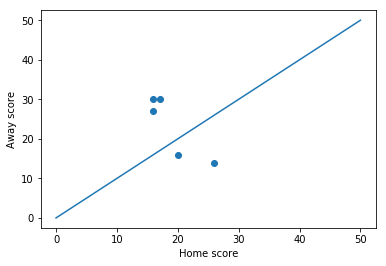

In [16]:
import matplotlib.pyplot as plt

plt.plot([0,50],[0,50], label="Tie")
plt.xlabel("Home score")
plt.ylabel("Away score")
x = sim_results['home_score']
y = sim_results['away_score']
plt.scatter(x,y)

plt.show()

Have a look at timing the performance

In [92]:
from time import time
t0 = time()
for i in range(1):
    game = simulate_game('CAR','NYG',quiet=True)
    print(game.result)
print("Finished in ",time()-t0,"seconds")

{'home': 'CAR', 'home_score': 28, 'away': 'NYG', 'away_score': 16, 'winner': 'CAR'}
Finished in  12.540180921554565 seconds


### Make a function to look and "predict" the outcome

In [14]:
def sim_many_games(home, away, iterations=25, **kwargs):
    games = []
    for i in range(iterations):
        g = simulate_game(home, away, **kwargs)
        games.append(g)
        print(g.result)
        
    # Make dataFrame from results, so that we can do things with them
    stats = {}
    sim_results = pd.DataFrame([g.result for g in games])
    win_pcts = sim_results.groupby(['winner'])['home'].agg('count')/float(iterations)
    stats['home_winpct'] = round(win_pcts[home],3)
    stats['away_winpct'] = round(win_pcts[away],3)
    stats['home_score_avg'] = round(sim_results.home_score.mean(),1)
    stats['away_score_avg'] = round(sim_results.away_score.mean(),1)
    
    return stats

In [39]:
t0 = time()
stats = sim_many_games('NYG','NYJ',iterations=25, quiet=True)
print("Finished in ",time()-t0,"seconds")
print(stats)

{'home': 'NYG', 'home_score': 16, 'away': 'NYJ', 'away_score': 20, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 10, 'away': 'NYJ', 'away_score': 14, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 23, 'away': 'NYJ', 'away_score': 24, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 17, 'away': 'NYJ', 'away_score': 27, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 21, 'away': 'NYJ', 'away_score': 20, 'winner': 'NYG'}
{'home': 'NYG', 'home_score': 10, 'away': 'NYJ', 'away_score': 22, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 21, 'away': 'NYJ', 'away_score': 12, 'winner': 'NYG'}
{'home': 'NYG', 'home_score': 20, 'away': 'NYJ', 'away_score': 14, 'winner': 'NYG'}
{'home': 'NYG', 'home_score': 24, 'away': 'NYJ', 'away_score': 19, 'winner': 'NYG'}
{'home': 'NYG', 'home_score': 20, 'away': 'NYJ', 'away_score': 14, 'winner': 'NYG'}
{'home': 'NYG', 'home_score': 3, 'away': 'NYJ', 'away_score': 36, 'winner': 'NYJ'}
{'home': 'NYG', 'home_score': 26, 'away': 'NYJ', 'away_score': 20, 'winner': 

In [41]:
t0 = time()
stats = sim_many_games('NYJ','NYG',iterations=25, quiet=True)
print("Finished in ",time()-t0,"seconds")
print(stats)

{'home': 'NYJ', 'home_score': 10, 'away': 'NYG', 'away_score': 22, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 29, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 26, 'away': 'NYG', 'away_score': 34, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 27, 'away': 'NYG', 'away_score': 13, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 22, 'away': 'NYG', 'away_score': 23, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 13, 'away': 'NYG', 'away_score': 9, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 16, 'away': 'NYG', 'away_score': 14, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 22, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 16, 'away': 'NYG', 'away_score': 14, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 17, 'away': 'NYG', 'away_score': 34, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 31, 'away': 'NYG', 'away_score': 26, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 30, 'away': 'NYG', 'away_score': 26, 'winner': 

In [48]:
# look at convergence of win percentage wrt iterations.
numlist = (5,10,15,20,25,35,50,100)
simresults = []
for i in numlist:
    t0 = time()
    stats = sim_many_games('PHI','CLE',iterations=i,quiet=True)
    time_taken = time()-t0
    print("Finished",i,"iterations in",time_taken,"seconds")
    stats['iterations'] = i
    stats['time'] = time_taken
    simresults.append(stats)

{'home': 'NYJ', 'home_score': 41, 'away': 'NYG', 'away_score': 33, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 30, 'away': 'NYG', 'away_score': 15, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 23, 'away': 'NYG', 'away_score': 34, 'winner': 'NYG'}
Finished 3 iterations in 44.52241826057434 seconds
{'home': 'NYJ', 'home_score': 36, 'away': 'NYG', 'away_score': 38, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 6, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 40, 'away': 'NYG', 'away_score': 20, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 3, 'away': 'NYG', 'away_score': 20, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 20, 'away': 'NYG', 'away_score': 17, 'winner': 'NYJ'}
Finished 5 iterations in 67.87118005752563 seconds
{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 30, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 31, 'away': 'NYG', 'away_score': 38, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 16, 'away': 'NYG', 'away_score

{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 35, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 27, 'away': 'NYG', 'away_score': 23, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 16, 'away': 'NYG', 'away_score': 17, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 10, 'away': 'NYG', 'away_score': 27, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 34, 'away': 'NYG', 'away_score': 27, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 13, 'away': 'NYG', 'away_score': 27, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 14, 'away': 'NYG', 'away_score': 34, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 24, 'away': 'NYG', 'away_score': 39, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 21, 'away': 'NYG', 'away_score': 29, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 44, 'away': 'NYG', 'away_score': 3, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 16, 'away': 'NYG', 'away_score': 17, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 49, 'away': 'NYG', 'away_score': 28, 'winner': 

{'home': 'NYJ', 'home_score': 26, 'away': 'NYG', 'away_score': 34, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 21, 'away': 'NYG', 'away_score': 21, 'winner': 'TIE'}
{'home': 'NYJ', 'home_score': 31, 'away': 'NYG', 'away_score': 10, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 27, 'away': 'NYG', 'away_score': 27, 'winner': 'TIE'}
{'home': 'NYJ', 'home_score': 10, 'away': 'NYG', 'away_score': 19, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 17, 'away': 'NYG', 'away_score': 23, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 7, 'away': 'NYG', 'away_score': 27, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 34, 'away': 'NYG', 'away_score': 20, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 21, 'away': 'NYG', 'away_score': 9, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 40, 'away': 'NYG', 'away_score': 35, 'winner': 'NYJ'}
{'home': 'NYJ', 'home_score': 14, 'away': 'NYG', 'away_score': 27, 'winner': 'NYG'}
{'home': 'NYJ', 'home_score': 22, 'away': 'NYG', 'away_score': 16, 'winner': '

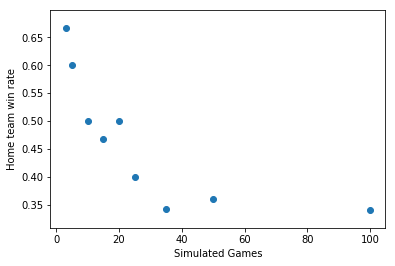

In [49]:
x = [ x['iterations'] for x in simresults ]
y = [ x['home_winpct'] for x in simresults ]
plt.scatter(x,y)
plt.xlabel("Simulated Games")
plt.ylabel("Home team win rate")

plt.show()

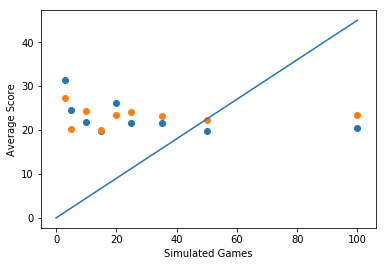

In [51]:
plt.plot([0,100],[0,45])
x = [ x['iterations'] for x in simresults ]
y1 = [ x['home_score_avg'] for x in simresults ]
y2 = [ x['away_score_avg'] for x in simresults ]
plt.scatter(x,y1)
plt.scatter(x,y2)
plt.xlabel("Simulated Games")
plt.ylabel("Average Score")

plt.show()

In [30]:
# Test parallel processing
from joblib import Parallel, delayed
import multiprocessing

iterations = 10

# Parallel run
t0 = time()
p_results = Parallel(n_jobs=2)(delayed(simulate_game)('NYG','NYJ',quiet=True) for i in range(iterations))
print([g.result for g in p_results])
print("Parallel run in",time()-t0,"seconds")


# Nonparallel run
t0 = time()
stats = sim_many_games('NYG','NYJ',iterations=iterations, quiet=True)
print("Serial run in",time()-t0,"seconds")
print(stats)

[{'home': 'NYG', 'home_score': 13, 'away': 'NYJ', 'away_score': 14, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 10, 'away': 'NYJ', 'away_score': 30, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 21, 'away': 'NYJ', 'away_score': 13, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 21, 'away': 'NYJ', 'away_score': 7, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 16, 'away': 'NYJ', 'away_score': 14, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 36, 'away': 'NYJ', 'away_score': 34, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 14, 'away': 'NYJ', 'away_score': 30, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 23, 'away': 'NYJ', 'away_score': 25, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 22, 'away': 'NYJ', 'away_score': 26, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 30, 'away': 'NYJ', 'away_score': 10, 'winner': 'NYG'}]
Parallel run in 87.95095634460449 seconds
{'home': 'NYG', 'home_score': 14, 'away': 'NYJ', 'away_score': 43, 'winner': 'NYJ'}
{'home': 'NYG', 'home_sc

In [31]:
# Parallel run
t0 = time()
p_results = Parallel(n_jobs=4)(delayed(simulate_game)('NYG','NYJ',quiet=True) for i in range(iterations))
print([g.result for g in p_results])
print("Parallel run in",time()-t0,"seconds")

[{'home': 'NYG', 'home_score': 40, 'away': 'NYJ', 'away_score': 28, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 16, 'away': 'NYJ', 'away_score': 10, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 17, 'away': 'NYJ', 'away_score': 10, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 10, 'away': 'NYJ', 'away_score': 24, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 19, 'away': 'NYJ', 'away_score': 17, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 16, 'away': 'NYJ', 'away_score': 31, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 20, 'away': 'NYJ', 'away_score': 19, 'winner': 'NYG'}, {'home': 'NYG', 'home_score': 21, 'away': 'NYJ', 'away_score': 23, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 3, 'away': 'NYJ', 'away_score': 23, 'winner': 'NYJ'}, {'home': 'NYG', 'home_score': 45, 'away': 'NYJ', 'away_score': 7, 'winner': 'NYG'}]
Parallel run in 70.8910620212555 seconds


In [15]:
# Test parallel processing
from joblib import Parallel, delayed
import multiprocessing

def sim_one_game(home, away, **kwargs):
    game_obj = simulate_game(home,away,**kwargs)
    print(game_obj.result)
    return game_obj

# New, parallelized function for simulating many games at once
def sim_many_games(home, away, iterations=25, **kwargs):
        
    game_objects = Parallel(n_jobs=3) \
                           (delayed(sim_one_game) \
                            (home, away, **kwargs) \
                            for i in range(iterations) )
            
    # Make dataFrame from results, so that we can do things with them
    stats = {}
    sim_results = pd.DataFrame([g.result for g in game_objects])
    win_pcts = sim_results.groupby(['winner'])['home'].agg('count')/float(iterations)
    
    # Write values to dictionary that will be returned as result of function
    stats['home_winpct'] = round(win_pcts[home],3) if home in win_pcts.index.values else 0
    stats['away_winpct'] = round(win_pcts[away],3) if away in win_pcts.index.values else 0
    stats['home_score_avg'] = round(sim_results.home_score.mean(),1)
    stats['away_score_avg'] = round(sim_results.away_score.mean(),1)
    stats['game_objects'] = sim_results
    
    return stats

In [43]:
numlist = (10,15,20,25,35,50,100,200)
convergenceresults = []
for i in numlist:
    t0 = time()
    stats = sim_many_games('PHI','CLE',iterations=i,quiet=True)
    time_taken = time()-t0
    print("Finished",i,"iterations in",time_taken,"seconds")
    print("")
    stats['iterations'] = i
    stats['time'] = time_taken
    simresults.append(stats)

{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 30, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 20, 'away': 'CLE', 'away_score': 31, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 26, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 37, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 31, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 37, 'away': 'CLE', 'away_score': 31, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 19, 'away': 'CLE', 'away_score': 24, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 20, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 34, 'away': 'CLE', 'away_score': 17, 'winner': 'PHI'}
Finished 10 iterations in 77.22399997711182 seconds

{'home': 'PHI', 'home_score': 22, 'away': 'CLE', 'away_score': 41, 'winner': 'CLE'}
{'home': 'PHI', 'home_s

{'home': 'PHI', 'home_score': 15, 'away': 'CLE', 'away_score': 35, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 9, 'away': 'CLE', 'away_score': 19, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 30, 'away': 'CLE', 'away_score': 13, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 10, 'away': 'CLE', 'away_score': 17, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 20, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 29, 'away': 'CLE', 'away_score': 34, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 21, 'away': 'CLE', 'away_score': 20, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 3, 'away': 'CLE', 'away_score': 10, 'winner': 'CLE'}
Finished 35 iterations in 271.86379837989807 seconds

{'home': 'PHI', 'home_score': 29, 'away': 'CLE', 'away_score': 20, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 20, 'away': 'CLE', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_sc

{'home': 'PHI', 'home_score': 25, 'away': 'CLE', 'away_score': 23, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 28, 'away': 'CLE', 'away_score': 22, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 15, 'away': 'CLE', 'away_score': 13, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 24, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 38, 'away': 'CLE', 'away_score': 9, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 31, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 24, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 28, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 20, 'away': 'CLE', 'away_score': 20, 'winner': 'TIE'}
{'home': 'PHI', 'home_score': 38, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 17, 'away': 'CLE', 'away_score': 31, 'winner': 

{'home': 'PHI', 'home_score': 17, 'away': 'CLE', 'away_score': 17, 'winner': 'TIE'}
{'home': 'PHI', 'home_score': 21, 'away': 'CLE', 'away_score': 7, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 24, 'away': 'CLE', 'away_score': 37, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 20, 'away': 'CLE', 'away_score': 12, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 23, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 31, 'away': 'CLE', 'away_score': 6, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 31, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 23, 'away': 'CLE', 'away_score': 31, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 6, 'away': 'CLE', 'away_score': 13, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 26, 'away': 'CLE', 'away_score': 27, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 10, 'away': 'CLE', 'away_score': 43, 'winner': 'C

{'home': 'PHI', 'home_score': 16, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 27, 'away': 'CLE', 'away_score': 10, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 33, 'away': 'CLE', 'away_score': 23, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 17, 'away': 'CLE', 'away_score': 20, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 17, 'away': 'CLE', 'away_score': 21, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 45, 'away': 'CLE', 'away_score': 16, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 10, 'away': 'CLE', 'away_score': 7, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 23, 'away': 'CLE', 'away_score': 14, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 31, 'away': 'CLE', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 23, 'away': 'CLE', 'away_score': 24, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 14, 'away': 'CLE', 'away_score': 28, 'winner': 'CLE'}
{'home': 'PHI', 'home_score': 16, 'away': 'CLE', 'away_score': 16, 'winner': 

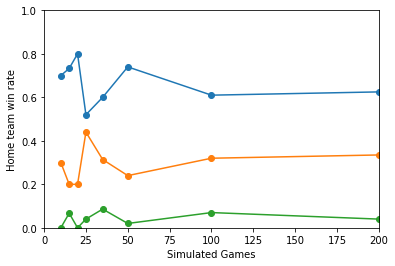

In [56]:
plt.axis((0,200,0,1))
x = [ x['iterations'] for x in simresults ]
y1 = [ x['home_winpct'] for x in simresults ]
y2 = [ x['away_winpct'] for x in simresults ]
y3 = [ 1-x['home_winpct']-x['away_winpct'] for x in simresults]
plt.scatter(x,y1)
plt.plot(x,y1)
plt.scatter(x,y2)
plt.plot(x,y2)
plt.scatter(x,y3); plt.plot(x,y3)
plt.xlabel("Simulated Games")
plt.ylabel("Home team win rate")

plt.show()

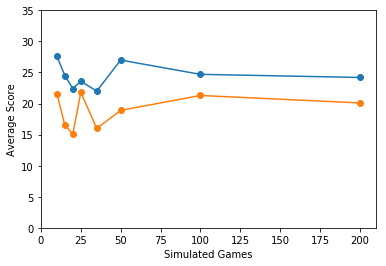

In [54]:
plt.axis((0,210,0,35))
x = [ x['iterations'] for x in simresults ]
y1 = [ x['home_score_avg'] for x in simresults ]
y2 = [ x['away_score_avg'] for x in simresults ]
plt.plot(x,y1); plt.scatter(x,y1)
plt.plot(x,y2); plt.scatter(x,y2)
plt.xlabel("Simulated Games")
plt.ylabel("Average Score")

plt.show()

In [59]:
sim_results

,away,away_score,home,home_score,winner
0,CLE,27,PHI,16,CLE
1,CLE,14,PHI,26,PHI
2,CLE,30,PHI,16,CLE
3,CLE,16,PHI,20,PHI
4,CLE,30,PHI,17,CLE


In [20]:
some_games = sim_many_games('CAR', 'ATL',
                            iterations=50,
                            quiet=True)
print(some_games)

{'home': 'CAR', 'home_score': 6, 'away': 'ATL', 'away_score': 22, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 37, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'ATL', 'away_score': 37, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 20, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 27, 'away': 'ATL', 'away_score': 52, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 27, 'away': 'ATL', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'ATL', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 51, 'away': 'ATL', 'away_score': 30, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 28, 'away': 'ATL', 'away_score': 31, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 7, 'away': 'ATL', 'away_score': 9, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 7, 'away': 'ATL', 'away_score': 27, 'winner': 'AT

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

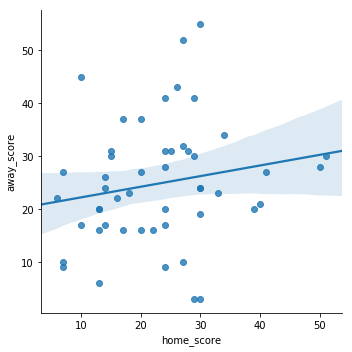

In [22]:
sns.lmplot(x='home_score', y='away_score', data=some_games['game_objects'])

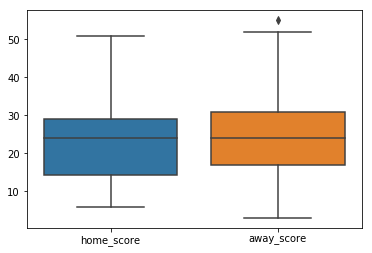

In [23]:
sns.boxplot(data=some_games['game_objects'][['home_score','away_score']])

  home away winner       score  value
0  CAR  ATL    ATL  away_score     22
1  CAR  ATL    CAR  away_score     16
2  CAR  ATL    ATL  away_score     37


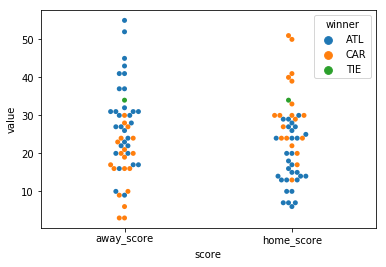

In [24]:
melted_df = pd.melt(some_games['game_objects'],
                    id_vars=['home','away','winner'],
                    var_name="score")
print(melted_df.head(3))

sns.swarmplot(x='score', y='value', data=melted_df, hue='winner')

In [17]:
def visualize_sim(game_dict):
    # Show score distribution for each team
    objects = game_dict['game_objects']
    for tm in ['home', 'away']:
        sns.distplot(objects[tm+"_score"].values,
                     bins=25,
                     hist_kws={"alpha":0.25},
                     kde_kws={"label":game_dict['game_objects'][tm].values[0]})

    # Place each team's average score on the plot
    home_avg = game_dict['home_score_avg']
    away_avg = game_dict['away_score_avg']
    plt.axvline(home_avg, linestyle='--', alpha=1, color='steelblue')
    plt.axvline(away_avg, linestyle='--', alpha=1, color='darkorange')

    # Set things with axes
    max_score = game_dict['game_objects'][['home_score','away_score']].max().values.max()
    plt.xlim( 0, max_score )
    plt.xlabel("Score")
    plt.tick_params(labelleft='off')
    plt.show()

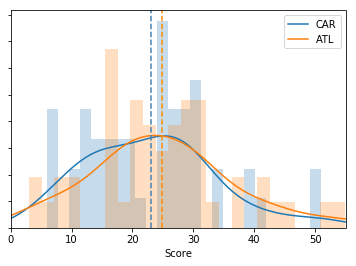

In [89]:
visualize_sim(some_games)

### Look at particular games at different points of the season.

Chiefs started the year hot, finished less so. Predict game vs. Raiders in week 6 at 5-1 as well as week 14 at 6-6.

In [80]:
# Simulate game in week 6
wk6_game = sim_many_games('OAK', 'KC',
                            season=2017,
                            week=6,
                            iterations=50,
                            quiet=True)
print(wk6_game)

{'home': 'OAK', 'home_score': 27, 'away': 'KC', 'away_score': 23, 'winner': 'OAK'}
{'home': 'OAK', 'home_score': 23, 'away': 'KC', 'away_score': 14, 'winner': 'OAK'}
{'home': 'OAK', 'home_score': 16, 'away': 'KC', 'away_score': 23, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 20, 'away': 'KC', 'away_score': 24, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 41, 'away': 'KC', 'away_score': 34, 'winner': 'OAK'}
{'home': 'OAK', 'home_score': 3, 'away': 'KC', 'away_score': 24, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 16, 'away': 'KC', 'away_score': 19, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 18, 'away': 'KC', 'away_score': 26, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 10, 'away': 'KC', 'away_score': 22, 'winner': 'KC'}
{'home': 'OAK', 'home_score': 30, 'away': 'KC', 'away_score': 14, 'winner': 'OAK'}
{'home': 'OAK', 'home_score': 33, 'away': 'KC', 'away_score': 25, 'winner': 'OAK'}
{'home': 'OAK', 'home_score': 13, 'away': 'KC', 'away_score': 20, 'winner': 'KC'}
{'home': 'OA

In [90]:
# Simulate week 14 game
wk14_game = sim_many_games('KC', 'OAK',
                           season=2017,
                           week=14,
                           iterations=50,
                           quiet=True)
print(wk14_game)

{'home': 'KC', 'home_score': 21, 'away': 'OAK', 'away_score': 19, 'winner': 'KC'}
{'home': 'KC', 'home_score': 33, 'away': 'OAK', 'away_score': 13, 'winner': 'KC'}
{'home': 'KC', 'home_score': 10, 'away': 'OAK', 'away_score': 20, 'winner': 'OAK'}
{'home': 'KC', 'home_score': 33, 'away': 'OAK', 'away_score': 26, 'winner': 'KC'}
{'home': 'KC', 'home_score': 40, 'away': 'OAK', 'away_score': 21, 'winner': 'KC'}
{'home': 'KC', 'home_score': 23, 'away': 'OAK', 'away_score': 14, 'winner': 'KC'}
{'home': 'KC', 'home_score': 27, 'away': 'OAK', 'away_score': 27, 'winner': 'TIE'}
{'home': 'KC', 'home_score': 16, 'away': 'OAK', 'away_score': 27, 'winner': 'OAK'}
{'home': 'KC', 'home_score': 25, 'away': 'OAK', 'away_score': 20, 'winner': 'KC'}
{'home': 'KC', 'home_score': 31, 'away': 'OAK', 'away_score': 10, 'winner': 'KC'}
{'home': 'KC', 'home_score': 16, 'away': 'OAK', 'away_score': 8, 'winner': 'KC'}
{'home': 'KC', 'home_score': 30, 'away': 'OAK', 'away_score': 30, 'winner': 'TIE'}
{'home': 'KC'

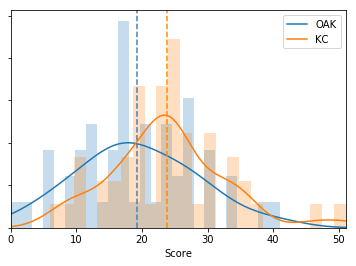

In [87]:
visualize_sim(wk6_game)

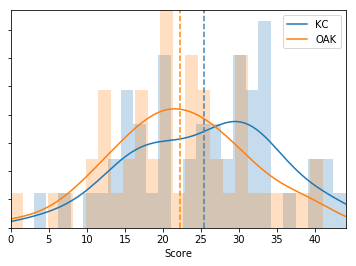

In [91]:
visualize_sim(wk14_game)

In [99]:
gamedata[ (gamedata.season==2017) & 
          (gamedata.week==7) &
          (gamedata.home=="KC") ]

,gameId,result,season,week,home,away,winner,home_score,away_score,OT
2141,400951571,"OAK 31, KC 30",2017,7,KC,OAK,OAK,30,31,0


In [100]:
gamedata[ (gamedata.season==2017) & 
          (gamedata.week==14) &
          (gamedata.home=="OAK") ]

,gameId,result,season,week,home,away,winner,home_score,away_score,OT
2246,400951654,"KC 26, OAK 15",2017,14,OAK,KC,KC,15,26,0


### Look at a whole season's worth of results
Are they any good?

{'home': 'CAR', 'home_score': 7, 'away': 'SF', 'away_score': 35, 'winner': 'SF'}
{'home': 'CAR', 'home_score': 29, 'away': 'SF', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 0, 'away': 'SF', 'away_score': 13, 'winner': 'SF'}
{'home': 'CAR', 'home_score': 14, 'away': 'SF', 'away_score': 29, 'winner': 'SF'}
{'home': 'CAR', 'home_score': 16, 'away': 'SF', 'away_score': 20, 'winner': 'SF'}
{'home': 'CAR', 'home_score': 24, 'away': 'SF', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'SF', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 26, 'away': 'SF', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 28, 'away': 'SF', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 14, 'away': 'SF', 'away_score': 20, 'winner': 'SF'}
{'home': 'CAR', 'home_score': 30, 'away': 'SF', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 25, 'away': 'SF', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CA

{'home': 'BUF', 'home_score': 21, 'away': 'CAR', 'away_score': 13, 'winner': 'BUF'}
{'home': 'BUF', 'home_score': 39, 'away': 'CAR', 'away_score': 15, 'winner': 'BUF'}
{'home': 'BUF', 'home_score': 37, 'away': 'CAR', 'away_score': 9, 'winner': 'BUF'}
{'home': 'BUF', 'home_score': 10, 'away': 'CAR', 'away_score': 17, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 10, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 10, 'away': 'CAR', 'away_score': 28, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 0, 'away': 'CAR', 'away_score': 37, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 0, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 20, 'away': 'CAR', 'away_score': 26, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 11, 'away': 'CAR', 'away_score': 14, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 24, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'home': 'BUF', 'home_score': 20, 'away': 'CAR', 'away_score': 13, 'winner': 'B

{'home': 'BUF', 'home_score': 17, 'away': 'CAR', 'away_score': 14, 'winner': 'BUF'}
{'home': 'BUF', 'home_score': 17, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 13, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 43, 'away': 'CAR', 'away_score': 21, 'winner': 'NO'}
{'home': 'NO', 'home_score': 55, 'away': 'CAR', 'away_score': 21, 'winner': 'NO'}
{'home': 'NO', 'home_score': 37, 'away': 'CAR', 'away_score': 15, 'winner': 'NO'}
{'home': 'NO', 'home_score': 21, 'away': 'CAR', 'away_score': 40, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 18, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 27, 'away': 'CAR', 'away_score': 26, 'winner': 'NO'}
{'home': 'NO', 'home_score': 17, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 17, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 13, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home

{'home': 'NO', 'home_score': 10, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'NO', 'home_score': 31, 'away': 'CAR', 'away_score': 38, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NE', 'away_score': 23, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 24, 'away': 'NE', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'NE', 'away_score': 17, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 13, 'away': 'NE', 'away_score': 37, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 7, 'away': 'NE', 'away_score': 35, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 40, 'away': 'NE', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NE', 'away_score': 28, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 21, 'away': 'NE', 'away_score': 7, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'NE', 'away_score': 30, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 21, 'away': 'NE', 'away_score': 42, 'winner': 'NE'}
{'home': 'CA

{'home': 'CAR', 'home_score': 24, 'away': 'NE', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'NE', 'away_score': 50, 'winner': 'NE'}
{'home': 'CAR', 'home_score': 13, 'away': 'DET', 'away_score': 24, 'winner': 'DET'}
{'home': 'CAR', 'home_score': 26, 'away': 'DET', 'away_score': 3, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 37, 'away': 'DET', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'DET', 'away_score': 25, 'winner': 'DET'}
{'home': 'CAR', 'home_score': 20, 'away': 'DET', 'away_score': 15, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'DET', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'DET', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 30, 'away': 'DET', 'away_score': 39, 'winner': 'DET'}
{'home': 'CAR', 'home_score': 13, 'away': 'DET', 'away_score': 27, 'winner': 'DET'}
{'home': 'CAR', 'home_score': 21, 'away': 'DET', 'away_score': 27, 'winner': 'DE

{'home': 'CAR', 'home_score': 24, 'away': 'DET', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'DET', 'away_score': 34, 'winner': 'DET'}
{'home': 'CAR', 'home_score': 36, 'away': 'DET', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 17, 'away': 'DET', 'away_score': 31, 'winner': 'DET'}
{'home': 'PHI', 'home_score': 3, 'away': 'CAR', 'away_score': 13, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 22, 'away': 'CAR', 'away_score': 37, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 39, 'away': 'CAR', 'away_score': 20, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 10, 'away': 'CAR', 'away_score': 6, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 17, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 10, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 39, 'away': 'CAR', 'away_score': 13, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 34, 'away': 'CAR', 'away_score': 21, 'winner': '

{'home': 'PHI', 'home_score': 43, 'away': 'CAR', 'away_score': 33, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 20, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'PHI', 'home_score': 9, 'away': 'CAR', 'away_score': 6, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 28, 'away': 'CAR', 'away_score': 17, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 14, 'away': 'CAR', 'away_score': 3, 'winner': 'PHI'}
{'home': 'PHI', 'home_score': 30, 'away': 'CAR', 'away_score': 17, 'winner': 'PHI'}
{'home': 'CAR', 'home_score': 20, 'away': 'CHI', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 25, 'away': 'CHI', 'away_score': 35, 'winner': 'CHI'}
{'home': 'CAR', 'home_score': 14, 'away': 'CHI', 'away_score': 6, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 12, 'away': 'CHI', 'away_score': 14, 'winner': 'CHI'}
{'home': 'CAR', 'home_score': 20, 'away': 'CHI', 'away_score': 19, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 38, 'away': 'CHI', 'away_score': 7, 'winner': 'CAR

{'home': 'CAR', 'home_score': 28, 'away': 'CHI', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'CHI', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 22, 'away': 'CHI', 'away_score': 10, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'CHI', 'away_score': 34, 'winner': 'CHI'}
{'home': 'CAR', 'home_score': 9, 'away': 'CHI', 'away_score': 18, 'winner': 'CHI'}
{'home': 'CAR', 'home_score': 24, 'away': 'CHI', 'away_score': 11, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 35, 'away': 'CHI', 'away_score': 55, 'winner': 'CHI'}
{'home': 'CAR', 'home_score': 37, 'away': 'CHI', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 26, 'away': 'TB', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'TB', 'away_score': 23, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 14, 'away': 'TB', 'away_score': 31, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 14, 'away': 'TB', 'away_score': 23, 'winner': 'TB'}


{'home': 'CAR', 'home_score': 34, 'away': 'TB', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'TB', 'away_score': 30, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 6, 'away': 'TB', 'away_score': 17, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 19, 'away': 'TB', 'away_score': 19, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 21, 'away': 'TB', 'away_score': 27, 'winner': 'TB'}
{'home': 'CAR', 'home_score': 33, 'away': 'TB', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 20, 'away': 'TB', 'away_score': 0, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 41, 'away': 'TB', 'away_score': 28, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 14, 'away': 'CAR', 'away_score': 22, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 17, 'away': 'CAR', 'away_score': 17, 'winner': 'TIE'}
{'home': 'ATL', 'home_score': 26, 'away': 'CAR', 'away_score': 16, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 23, 'away': 'CAR', 'away_score': 30, 'winner': 'CAR'}
{'hom

{'home': 'ATL', 'home_score': 41, 'away': 'CAR', 'away_score': 44, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 13, 'away': 'CAR', 'away_score': 14, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 16, 'away': 'CAR', 'away_score': 16, 'winner': 'TIE'}
{'home': 'ATL', 'home_score': 40, 'away': 'CAR', 'away_score': 26, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 24, 'away': 'CAR', 'away_score': 12, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 13, 'away': 'CAR', 'away_score': 16, 'winner': 'CAR'}
{'home': 'ATL', 'home_score': 23, 'away': 'CAR', 'away_score': 23, 'winner': 'TIE'}
{'home': 'ATL', 'home_score': 31, 'away': 'CAR', 'away_score': 16, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 18, 'away': 'CAR', 'away_score': 17, 'winner': 'ATL'}
{'home': 'ATL', 'home_score': 31, 'away': 'CAR', 'away_score': 16, 'winner': 'ATL'}
{'home': 'MIA', 'home_score': 40, 'away': 'CAR', 'away_score': 27, 'winner': 'MIA'}
{'home': 'MIA', 'home_score': 30, 'away': 'CAR', 'away_score': 14, 'winner':

{'home': 'MIA', 'home_score': 14, 'away': 'CAR', 'away_score': 33, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 29, 'away': 'CAR', 'away_score': 36, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 30, 'away': 'CAR', 'away_score': 13, 'winner': 'MIA'}
{'home': 'MIA', 'home_score': 17, 'away': 'CAR', 'away_score': 17, 'winner': 'TIE'}
{'home': 'MIA', 'home_score': 20, 'away': 'CAR', 'away_score': 10, 'winner': 'MIA'}
{'home': 'MIA', 'home_score': 9, 'away': 'CAR', 'away_score': 10, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 7, 'away': 'CAR', 'away_score': 10, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 3, 'away': 'CAR', 'away_score': 45, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 14, 'away': 'CAR', 'away_score': 26, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 17, 'away': 'CAR', 'away_score': 19, 'winner': 'CAR'}
{'home': 'MIA', 'home_score': 27, 'away': 'CAR', 'away_score': 13, 'winner': 'MIA'}
{'home': 'MIA', 'home_score': 0, 'away': 'CAR', 'away_score': 10, 'winner': 'CA

{'home': 'CAR', 'home_score': 33, 'away': 'NYJ', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 21, 'away': 'NYJ', 'away_score': 20, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 16, 'away': 'NYJ', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NYJ', 'away_score': 33, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 10, 'away': 'NYJ', 'away_score': 33, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 6, 'away': 'NYJ', 'away_score': 27, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 13, 'away': 'NYJ', 'away_score': 20, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 14, 'away': 'NYJ', 'away_score': 31, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 23, 'away': 'NYJ', 'away_score': 34, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 7, 'away': 'NYJ', 'away_score': 19, 'winner': 'NYJ'}
{'home': 'CAR', 'home_score': 29, 'away': 'NYJ', 'away_score': 3, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 35, 'away': 'NYJ', 'away_score': 24, 'winner': 'C

{'home': 'CAR', 'home_score': 23, 'away': 'NO', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'NO', 'away_score': 23, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 3, 'away': 'NO', 'away_score': 17, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 28, 'away': 'NO', 'away_score': 24, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 16, 'away': 'NO', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 23, 'away': 'NO', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 19, 'away': 'NO', 'away_score': 21, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 26, 'away': 'NO', 'away_score': 21, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 31, 'away': 'NO', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 19, 'away': 'NO', 'away_score': 21, 'winner': 'NO'}
{'home': 'CAR', 'home_score': 29, 'away': 'NO', 'away_score': 17, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'NO', 'away_score': 21, 'winner': 'CAR'}
{'home': 

{'home': 'MIN', 'home_score': 6, 'away': 'CAR', 'away_score': 12, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 10, 'away': 'CAR', 'away_score': 52, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 27, 'away': 'CAR', 'away_score': 13, 'winner': 'MIN'}
{'home': 'MIN', 'home_score': 21, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 26, 'away': 'CAR', 'away_score': 0, 'winner': 'MIN'}
{'home': 'MIN', 'home_score': 27, 'away': 'CAR', 'away_score': 27, 'winner': 'TIE'}
{'home': 'MIN', 'home_score': 37, 'away': 'CAR', 'away_score': 14, 'winner': 'MIN'}
{'home': 'MIN', 'home_score': 17, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 19, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 18, 'away': 'CAR', 'away_score': 20, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 19, 'away': 'CAR', 'away_score': 21, 'winner': 'CAR'}
{'home': 'MIN', 'home_score': 12, 'away': 'CAR', 'away_score': 17, 'winner': '

{'home': 'GB', 'home_score': 24, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 10, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 20, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 9, 'away': 'CAR', 'away_score': 13, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 27, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 10, 'away': 'CAR', 'away_score': 16, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 23, 'away': 'CAR', 'away_score': 13, 'winner': 'GB'}
{'home': 'GB', 'home_score': 37, 'away': 'CAR', 'away_score': 14, 'winner': 'GB'}
{'home': 'GB', 'home_score': 39, 'away': 'CAR', 'away_score': 24, 'winner': 'GB'}
{'home': 'GB', 'home_score': 30, 'away': 'CAR', 'away_score': 10, 'winner': 'GB'}
{'home': 'GB', 'home_score': 27, 'away': 'CAR', 'away_score': 31, 'winner': 'CAR'}
{'home': 'GB', 'home_score': 25, 'away': 'CAR', 'away_score': 26, 'winner': 'CAR'}
{'home': 

{'home': 'TB', 'home_score': 14, 'away': 'CAR', 'away_score': 24, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 41, 'away': 'CAR', 'away_score': 42, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 17, 'away': 'CAR', 'away_score': 13, 'winner': 'TB'}
{'home': 'TB', 'home_score': 37, 'away': 'CAR', 'away_score': 20, 'winner': 'TB'}
{'home': 'TB', 'home_score': 31, 'away': 'CAR', 'away_score': 9, 'winner': 'TB'}
{'home': 'TB', 'home_score': 25, 'away': 'CAR', 'away_score': 29, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 9, 'away': 'CAR', 'away_score': 36, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 34, 'away': 'CAR', 'away_score': 23, 'winner': 'TB'}
{'home': 'TB', 'home_score': 7, 'away': 'CAR', 'away_score': 27, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 24, 'away': 'CAR', 'away_score': 43, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 17, 'away': 'CAR', 'away_score': 45, 'winner': 'CAR'}
{'home': 'TB', 'home_score': 13, 'away': 'CAR', 'away_score': 23, 'winner': 'CAR'}
{'home': 'T

{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 26, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 16, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 27, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 20, 'away': 'ATL', 'away_score': 20, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 9, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 27, 'away': 'ATL', 'away_score': 38, 'winner': 'ATL'}
{'home': 'CAR', 'home_score': 23, 'away': 'ATL', 'away_score': 13, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 13, 'away': 'ATL', 'away_score': 0, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 44, 'away': 'ATL', 'away_score': 18, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 24, 'away': 'ATL', 'away_score': 24, 'winner': 'TIE'}
{'home': 'CAR', 'home_score': 26, 'away': 'ATL', 'away_score': 3, 'winner': 'CAR'}
{'home': 'CAR', 'home_score': 14, 'away': 'ATL', 'away_score': 24, 'winner': 'A

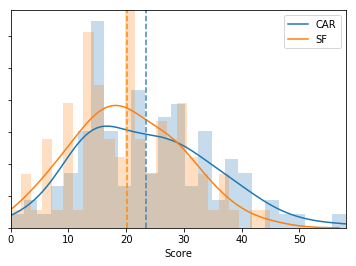

Real Result:
     home away        result
2060  CAR   SF  CAR 23, SF 3


Simulated Game


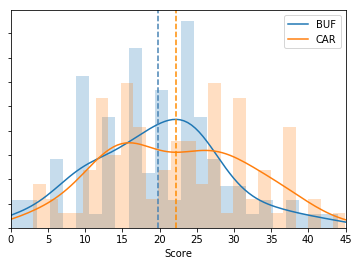

Real Result:
     home away        result
2071  BUF  CAR  CAR 9, BUF 3


Simulated Game


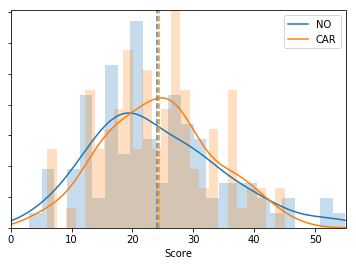

Real Result:
     home away         result
2091   NO  CAR  NO 34, CAR 13


Simulated Game


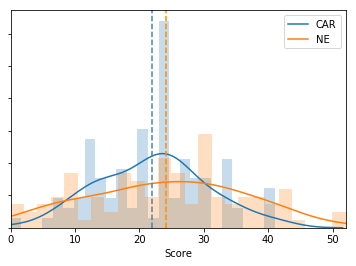

Real Result:
     home away         result
2103  CAR   NE  CAR 33, NE 30


Simulated Game


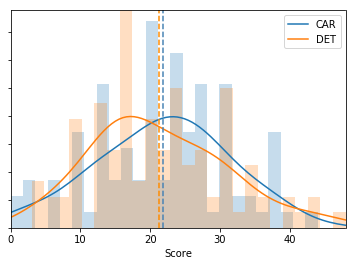

Real Result:
     home away          result
2116  CAR  DET  CAR 27, DET 24


Simulated Game


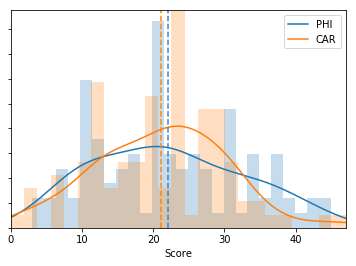

Real Result:
     home away          result
2127  PHI  CAR  PHI 28, CAR 23


Simulated Game


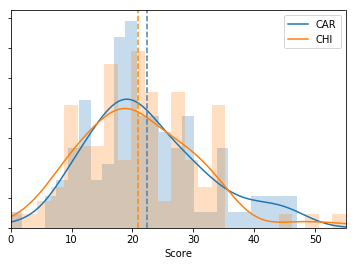

Real Result:
     home away         result
2143  CAR  CHI  CHI 17, CAR 3


Simulated Game


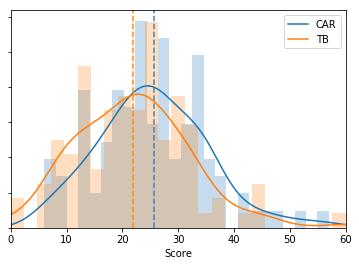

Real Result:
     home away        result
2164  CAR   TB  CAR 17, TB 3


Simulated Game


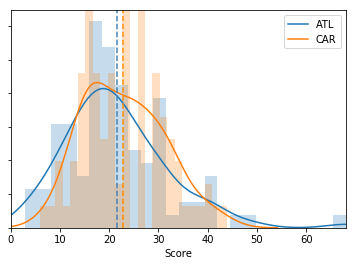

Real Result:
     home away          result
2174  ATL  CAR  CAR 20, ATL 17


Simulated Game


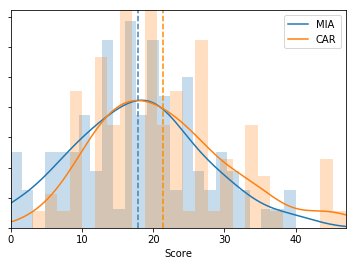

Real Result:
     home away          result
2195  MIA  CAR  CAR 45, MIA 21


Simulated Game


KeyError: 11

In [18]:
simmed_games = {}
real_games = {}
weeks = 17
for wk in range(1,weeks+1):
    real_game = gamedata[
                          (gamedata.season==2017) &
                          (gamedata.week==wk) &
                          ((gamedata.home=="CAR") | (gamedata.away=="CAR"))
                        ]
    
    if len(real_game.index > 0):
        real_games[wk] = real_game
        
        home_tm = real_game.home.values[0]
        away_tm = real_game.away.values[0]
        sim_game = sim_many_games(home_tm, away_tm,
                                  season=2017,
                                  week=wk,
                                  iterations=100,
                                  quiet=True)
        simmed_games[wk] = sim_game
        
        
for wk in range(1,weeks+1):
    print("Simulated Game")
    visualize_sim(simmed_games[wk])
    print("Real Result:")
    cols = ['home','away','result']
    print(real_games[wk][cols])
    print("\n")

In [39]:
def simmed_summary(games_dict):
    # As input, use dictionary output from sim_many_games
    g = games_dict
    df_dict = {}
    df_dict['home'] = g['game_objects'].home.values[0]
    df_dict['away'] = g['game_objects'].away.values[0]
    df_dict['home_score'] = g['home_score_avg']
    df_dict['away_score'] = g['away_score_avg']
    df_dict['home_winpct'] = g['home_winpct']
    
    # Make Series from dict. Then dataframe from series.
    df = pd.DataFrame(pd.Series(df_dict)).transpose()
    return df[['home','home_score', 
               'away','away_score', 'home_winpct']]
    
simmed_summary(simmed_games[1])

,home,home_score,away,away_score,home_winpct
0,CAR,23.5,SF,20.1,0.54


Simulated Game


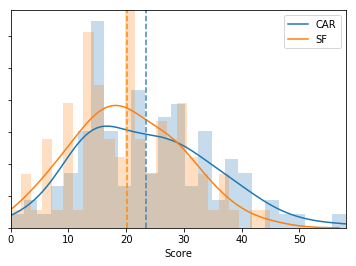

  home home_score away away_score home_winpct
0  CAR       23.5   SF       20.1        0.54
Real Result:
     home away        result
2060  CAR   SF  CAR 23, SF 3


Simulated Game


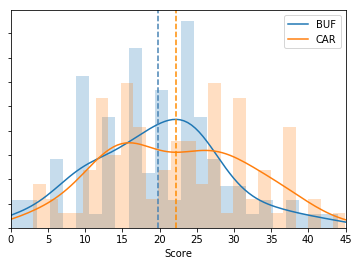

  home home_score away away_score home_winpct
0  BUF       19.8  CAR       22.2         0.4
Real Result:
     home away        result
2071  BUF  CAR  CAR 9, BUF 3


Simulated Game


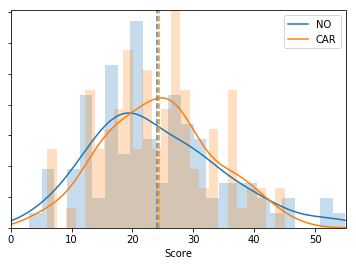

  home home_score away away_score home_winpct
0   NO         24  CAR       24.3        0.41
Real Result:
     home away         result
2091   NO  CAR  NO 34, CAR 13


Simulated Game


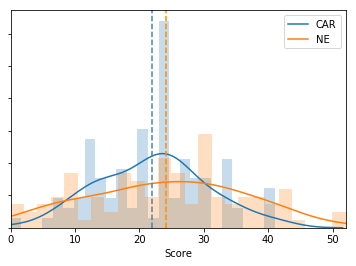

  home home_score away away_score home_winpct
0  CAR         22   NE       24.1         0.4
Real Result:
     home away         result
2103  CAR   NE  CAR 33, NE 30


Simulated Game


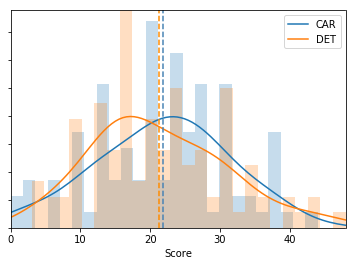

  home home_score away away_score home_winpct
0  CAR       21.8  DET       21.2        0.47
Real Result:
     home away          result
2116  CAR  DET  CAR 27, DET 24


Simulated Game


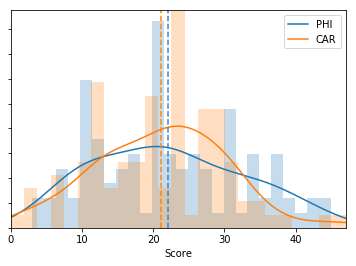

  home home_score away away_score home_winpct
0  PHI       22.1  CAR       21.1        0.51
Real Result:
     home away          result
2127  PHI  CAR  PHI 28, CAR 23


Simulated Game


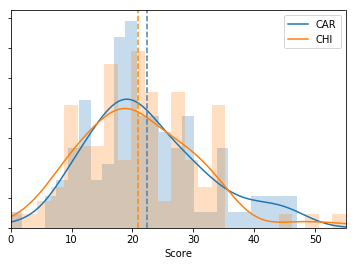

  home home_score away away_score home_winpct
0  CAR       22.4  CHI       20.9        0.46
Real Result:
     home away         result
2143  CAR  CHI  CHI 17, CAR 3


Simulated Game


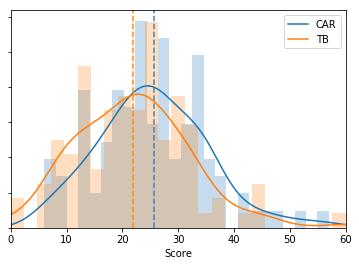

  home home_score away away_score home_winpct
0  CAR       25.6   TB       21.9        0.61
Real Result:
     home away        result
2164  CAR   TB  CAR 17, TB 3


Simulated Game


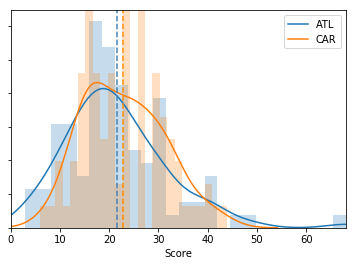

  home home_score away away_score home_winpct
0  ATL       21.5  CAR       22.9        0.43
Real Result:
     home away          result
2174  ATL  CAR  CAR 20, ATL 17


Simulated Game


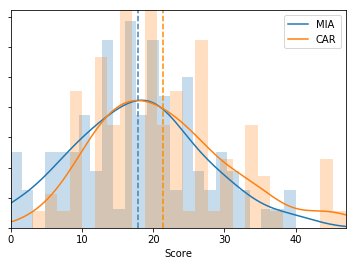

  home home_score away away_score home_winpct
0  MIA       17.9  CAR       21.4        0.35
Real Result:
     home away          result
2195  MIA  CAR  CAR 45, MIA 21


Simulated Game


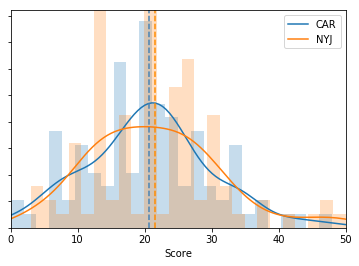

  home home_score away away_score home_winpct
0  CAR       20.6  NYJ       21.5        0.51
Real Result:
     home away          result
2218  CAR  NYJ  CAR 35, NYJ 27


Simulated Game


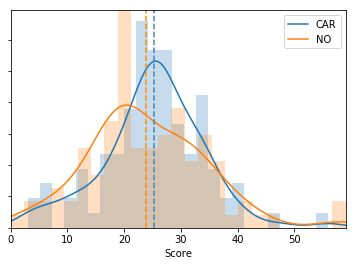

  home home_score away away_score home_winpct
0  CAR       25.2   NO       23.9        0.54
Real Result:
     home away         result
2238  CAR   NO  NO 31, CAR 21


Simulated Game


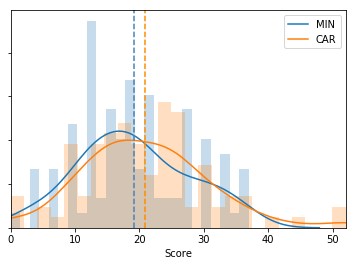

  home home_score away away_score home_winpct
0  MIN       19.1  CAR       20.9        0.41
Real Result:
     home away          result
2249  MIN  CAR  CAR 31, MIN 24


Simulated Game


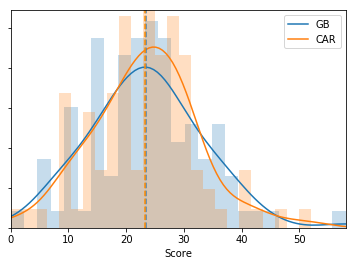

  home home_score away away_score home_winpct
0   GB       23.5  CAR       23.3        0.45
Real Result:
     home away         result
2267   GB  CAR  CAR 31, GB 24


Simulated Game


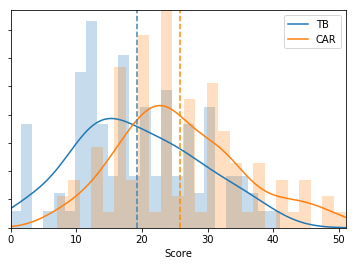

  home home_score away away_score home_winpct
0   TB       19.2  CAR       25.8        0.26
Real Result:
     home away         result
2284   TB  CAR  CAR 22, TB 19


Simulated Game


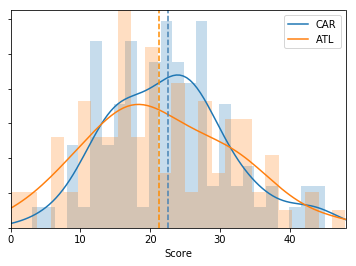

  home home_score away away_score home_winpct
0  CAR       22.6  ATL       21.3        0.51
Real Result:
     home away          result
2297  CAR  ATL  ATL 22, CAR 10




In [40]:
for wk in range(1,18):
    if wk in simmed_games.keys():
        print("Simulated Game:")
        visualize_sim(simmed_games[wk])
        print(simmed_summary(simmed_games[wk]))
        print("Real Result:")
        cols = ['home','away','result']
        print(real_games[wk][cols])
        print("\n")